In [1]:
import pandas as pd
import unicodedata
import plotly.express as px

def normalize_name( country_name ):
    to_ascii = lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode()

    return country_name.\
        apply( to_ascii).\
        str.replace(' And ',' and ' ).\
        str.replace('^Bonaire.*$','Bonaire',regex=True).\
        str.replace('^Brunei.*$','Brunei',regex=True).\
        str.replace('Virgin Islands (British)','British Virgin Islands').\
        str.replace('Virgin Islands (U.S.)','Us Virgin Islands').\
        str.replace('Cabo Verde','Cape Verde').\
        str.replace('Congo (Democratic Republic Of The)','Democratic Republic of the Congo').\
        str.replace('^Falkland Islands.*$','Falkland Islands',regex=True).\
        str.replace('Guinea Bissau','Guinea-Bissau').\
        str.replace('^Hong Kong.*$','Hong Kong', regex=True).\
        str.replace(' Of ',' of ').\
        str.replace("Cote D'Ivoire",'Ivory Coast').\
        str.replace('^Macao.*$','Macao', regex=True).\
        str.replace('Micronesia (Federated States of)','Micronesia').\
        str.replace('Korea, Republic of','North Korea').\
        str.replace('North Macedonia','Macedonia').\
        str.replace('^Palestine.*$','Palestine',regex=True).\
        str.replace('^Republic of the Congo$','Congo', regex=True).\
        str.replace('^Saint Helena.*$','Saint Helena', regex=True).\
        str.replace(' The ',' the ').\
        str.replace('Saint Pierre','Saint-Pierre').\
        str.replace('^Sint Maarten.*$','Sint Maarten', regex=True)

ISO=r'C:\Users\dell\Desktop\MyDocs\Docs\MK\continents2.csv'
df_iso = pd.read_csv(ISO).rename(columns={'name':'country'})
df_iso.country = normalize_name(df_iso.country)

QOF=r'C:\Users\dell\Desktop\MyDocs\Docs\MK\Quality_of_Life.csv'
df_qof = pd.read_csv(QOF)
df_qof.columns = df_qof.columns.str.replace(' ','_')
df_qof.country = normalize_name(df_qof.country)

df_qof = pd.merge(df_qof, df_iso[['country','alpha-3']], on='country')

In [2]:
categories = [ x for x in df_qof.columns if "_Category" in x]
IDs = ['country','alpha-3']
cols = IDs + categories

_ = df_qof[cols].melt(id_vars = IDs, var_name='category', value_name='value')

color_map = {
    'Very Low': 'blue',
    'Low': 'cyan',
    'Moderate': 'green',
    'High': 'orange',
    'Very High': 'red',
    }

fig = px.choropleth(
    data_frame = _,
    locations='alpha-3',
    locationmode='ISO-3',
    scope='world',
    color_discrete_map=color_map,

     
    color='value',
    width=1200,
    height=800,
    animation_frame='category',
    hover_data='country'
    )
fig.update_layout(title_text='Quality of Life Ratings', title_x=0.5)
fig.show(renderer='iframe')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tabulate import tabulate
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv(r'C:\Users\dell\Desktop\MyDocs\Docs\MK\Quality_of_Life.csv')
df = data.copy()
df.head()

,country,Purchasing Power Value,Purchasing Power Category,Safety Value,Safety Category,Health Care Value,Health Care Category,Climate Value,Climate Category,Cost of Living Value,Cost of Living Category,Property Price to Income Value,Property Price to Income Category,Traffic Commute Time Value,Traffic Commute Time Category,Pollution Value,Pollution Category,Quality of Life Value,Quality of Life Category
0,Afghanistan,32.15,'Very Low',25.33,'Low',24.24,'Low',0.00,NaN,21.08,'Very Low',7.8,'Low',56.17,'Very High',84.44,'Very High',0.0,NaN
1,Aland Islands,125.01,'Very High',71.81,'High',79.72,'High',0.00,NaN,53.44,'Low',5.33,'Low',19.05,'Very Low',18.05,'Very Low',0.0,NaN
2,Albania,42.82,'Low',55.52,'Moderate',48.21,'Moderate',86.43,'Very High',40.85,'Low',14.88,'High',36.74,'Moderate',77.25,'High',': 104.16','Low'
3,Alderney,0.00,NaN,83.79,'Very High',100.00,'Very High',0.00,NaN,0.00,NaN,0.0,NaN,5.00,'Very Low',1.72,'Very Low',0.0,NaN
4,Algeria,27.60,'Very Low',47.54,'Moderate',54.43,'Moderate',94.82,'Very High',25.31,'Very Low',21.7,'Very High',45.09,'High',63.87,'High',': 98.83','Very Low'


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            236 non-null    object 
 1   Purchasing Power Value             236 non-null    float64
 2   Purchasing Power Category          190 non-null    object 
 3   Safety Value                       236 non-null    float64
 4   Safety Category                    234 non-null    object 
 5   Health Care Value                  236 non-null    float64
 6   Health Care Category               221 non-null    object 
 7   Climate Value                      236 non-null    float64
 8   Climate Category                   114 non-null    object 
 9   Cost of Living Value               236 non-null    float64
 10  Cost of Living Category            191 non-null    object 
 11  Property Price to Income Value     236 non-null    object 

In [6]:
df.shape

(236, 19)

In [7]:
df = df.applymap(lambda x: x.strip("'") if isinstance(x, str) else x)

In [8]:
convert_to_float = ['Property Price to Income Value', 'Quality of Life Value']
df[convert_to_float] = df[convert_to_float].apply(pd.to_numeric, errors='coerce')

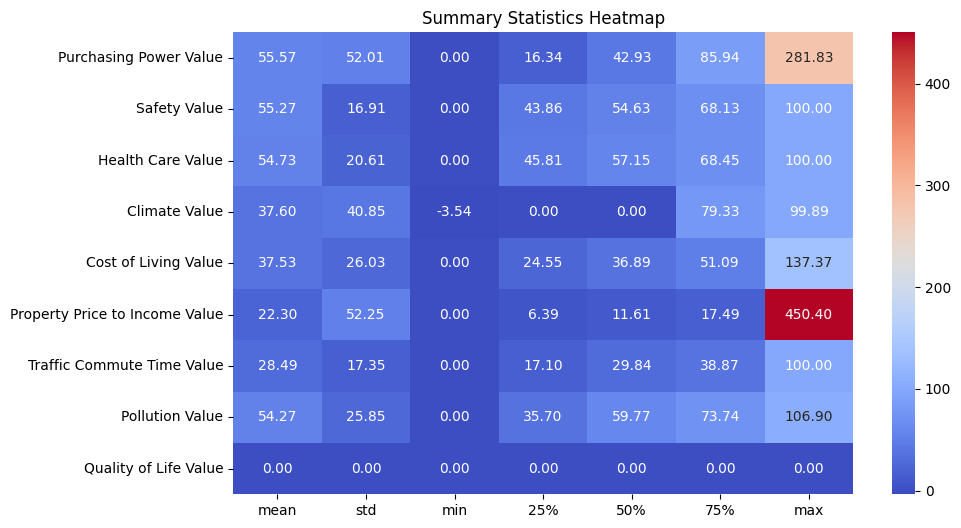

In [9]:
desc = df.describe().T
plt.figure(figsize=(10, 6))
sns.heatmap(desc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']], annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Summary Statistics Heatmap')
plt.show()

In [10]:
df.isnull().sum()

country                                0
Purchasing Power Value                 0
Purchasing Power Category             46
Safety Value                           0
Safety Category                        2
Health Care Value                      0
Health Care Category                  15
Climate Value                          0
Climate Category                     122
Cost of Living Value                   0
Cost of Living Category               45
Property Price to Income Value         3
Property Price to Income Category     21
Traffic Commute Time Value             0
Traffic Commute Time Category         29
Pollution Value                        0
Pollution Category                    10
Quality of Life Value                114
Quality of Life Category             122
dtype: int64

In [11]:
missing_percentage = df.isnull().mean() * 100

missing_table = pd.DataFrame({
    'Missing Data Percentage (%)': missing_percentage
}).reset_index().rename(columns={'index': 'Column'})

print(tabulate(missing_table, headers='keys', tablefmt='grid', showindex=False))

+-----------------------------------+-------------------------------+
| Column                            |   Missing Data Percentage (%) |
+===================================+===============================+
| country                           |                      0        |
+-----------------------------------+-------------------------------+
| Purchasing Power Value            |                      0        |
+-----------------------------------+-------------------------------+
| Purchasing Power Category         |                     19.4915   |
+-----------------------------------+-------------------------------+
| Safety Value                      |                      0        |
+-----------------------------------+-------------------------------+
| Safety Category                   |                      0.847458 |
+-----------------------------------+-------------------------------+
| Health Care Value                 |                      0        |
+-------------------

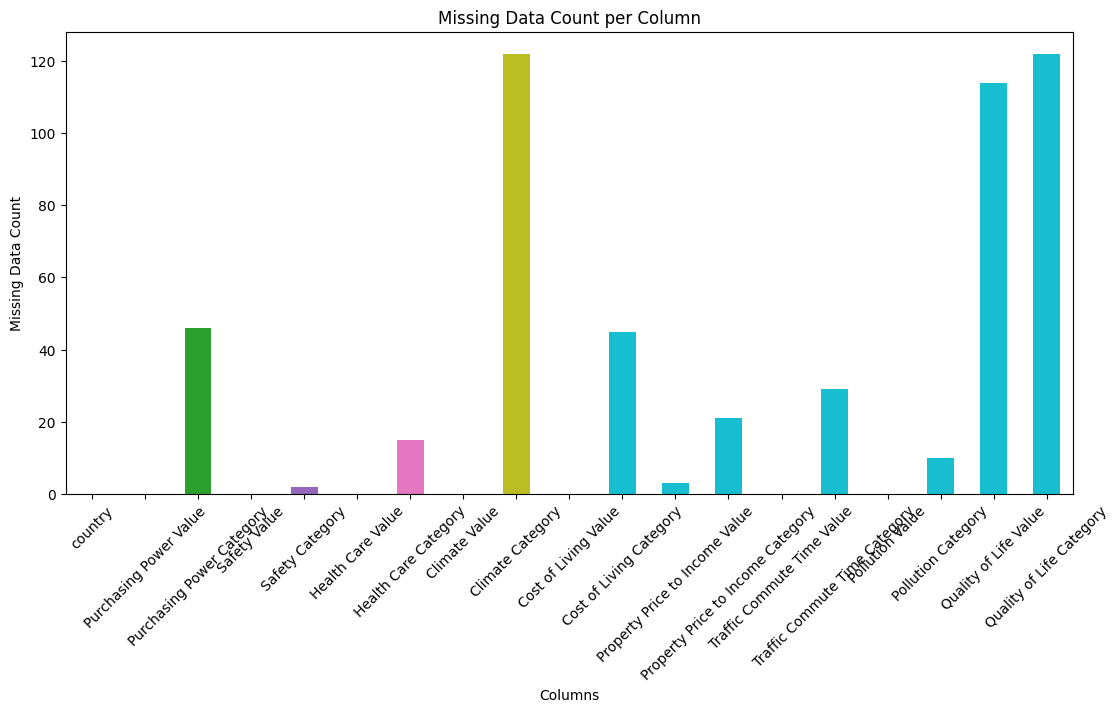

In [12]:
missing_data_count = df.isnull().sum()
colors = plt.cm.tab10(range(len(missing_data_count)))

missing_data_count.plot(kind='bar', color=colors, figsize=(13,6))
plt.title('Missing Data Count per Column')
plt.xlabel('Columns')
plt.ylabel('Missing Data Count')
plt.xticks(rotation=45)
plt.show()

In [13]:
numeric_columns = df.select_dtypes(include=['float64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

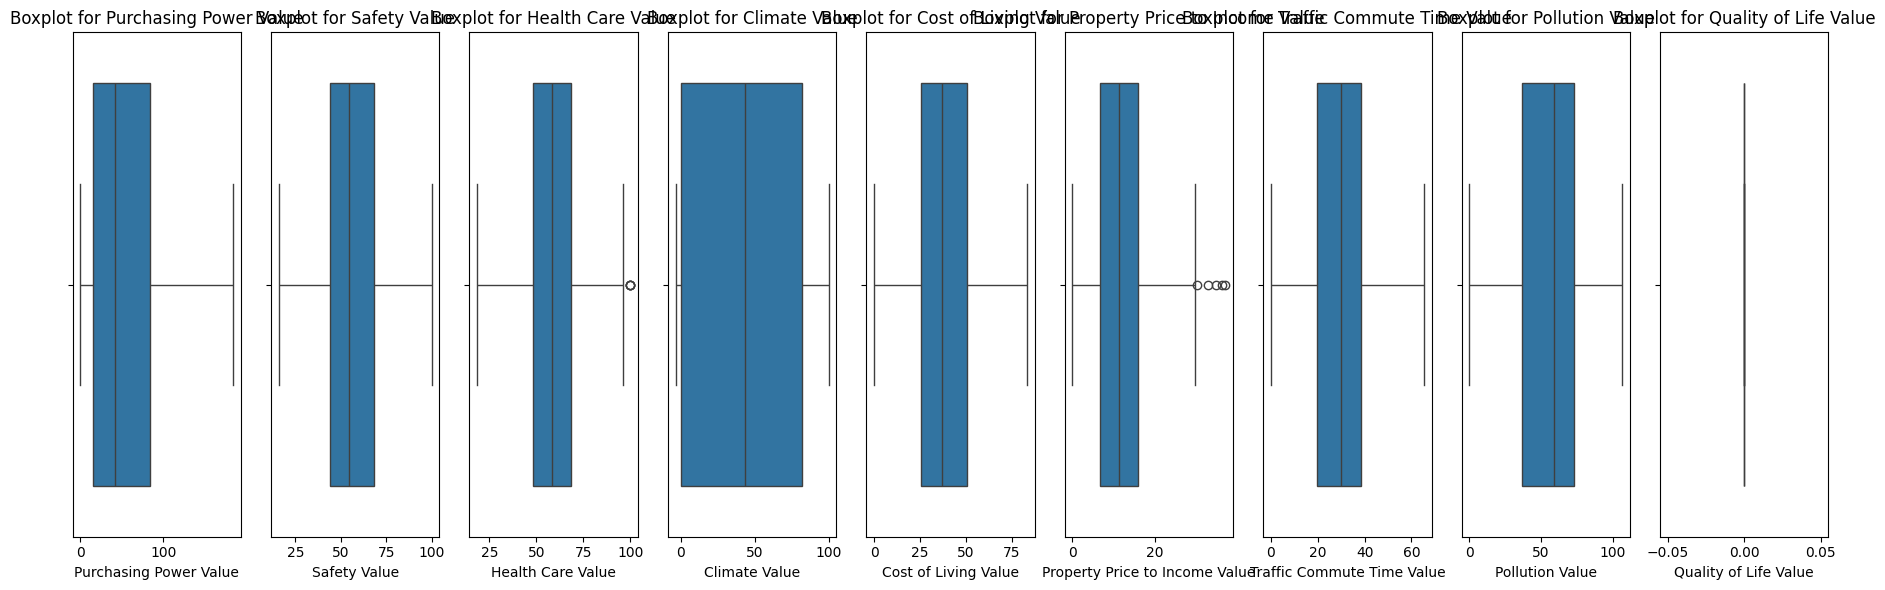

In [14]:
def remove_outliers(df):
    num_columns = len(df.select_dtypes(include=['float64', 'int64']).columns)
    
    fig, axes = plt.subplots(1, num_columns, figsize=(18, 6))
    
    for i, column in enumerate(df.select_dtypes(include=['float64', 'int64']).columns):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        
        sns.boxplot(x=df[column], ax=axes[i])
        axes[i].set_title(f'Boxplot for {column}')
    
    plt.tight_layout()
    plt.show()
    
    return df

df = remove_outliers(df)

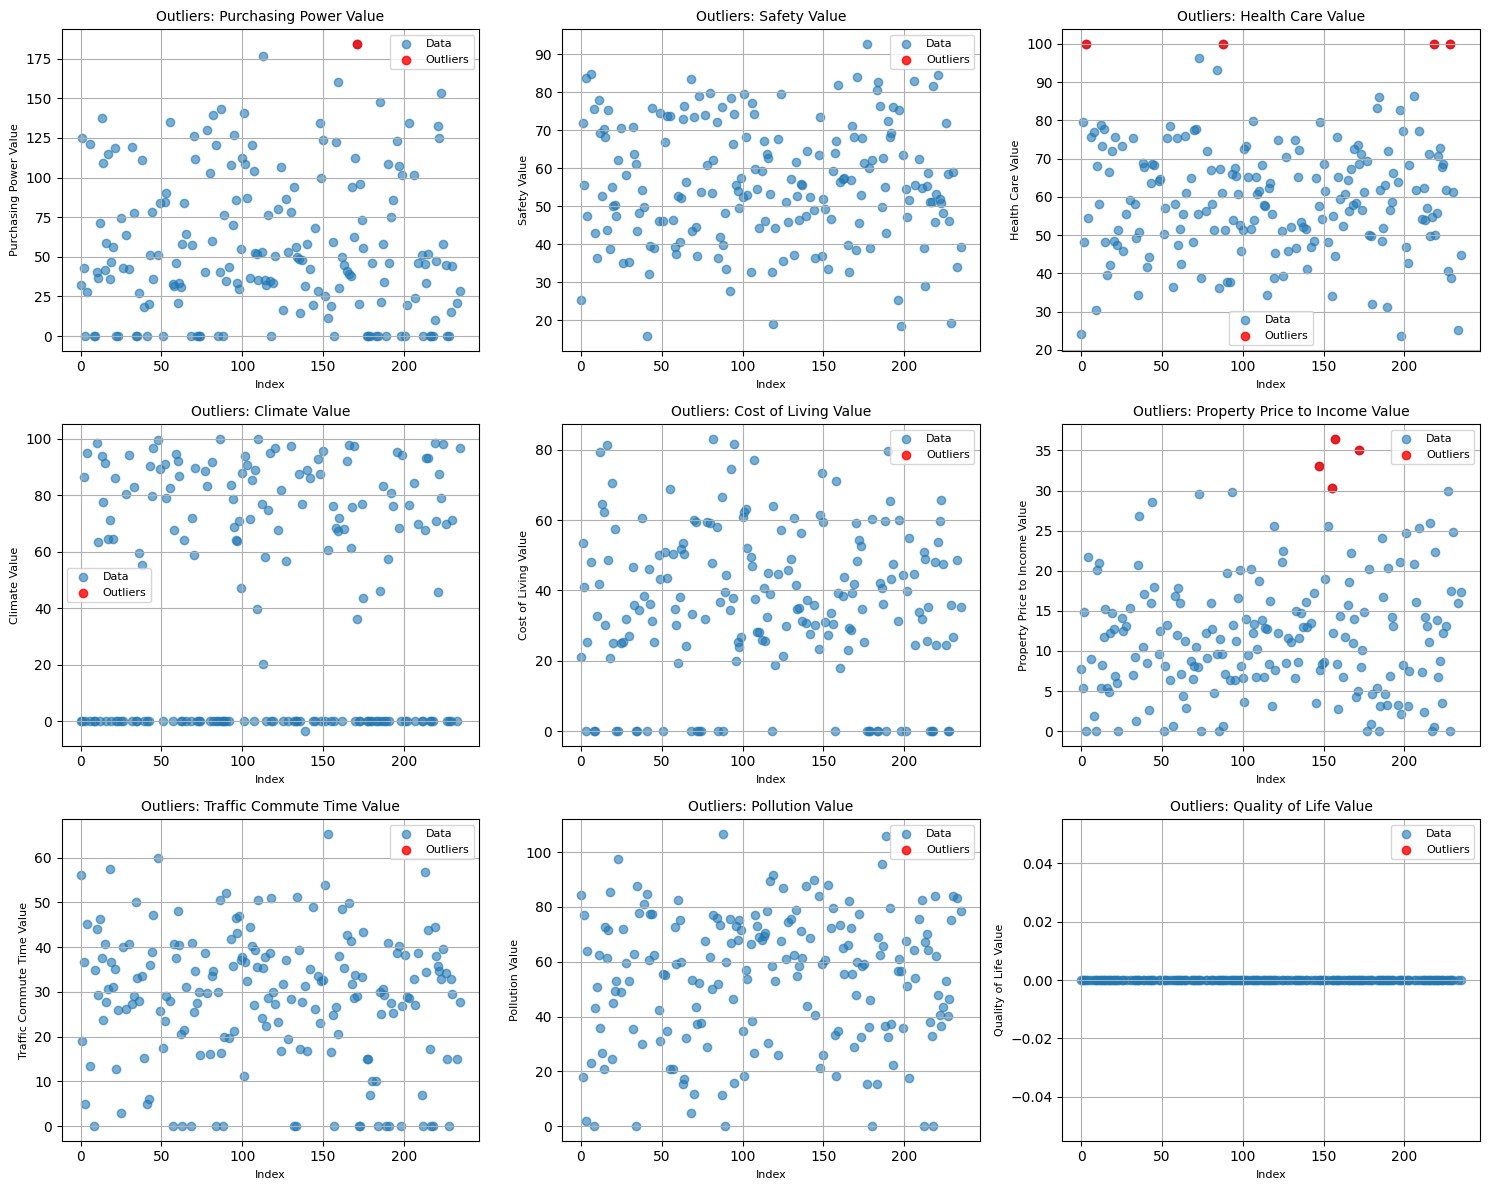

In [15]:
def plot_outliers_iqr(data):

    numeric_columns = data.select_dtypes(include=[np.number]).columns
    threshold = 1.5
    n_cols = 3 
    n_rows = -(-len(numeric_columns) // n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), squeeze=False)
    axes = axes.flatten() 
    
    for idx, column in enumerate(numeric_columns):
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        outliers = (data[column] < lower_bound) | (data[column] > upper_bound)

        axes[idx].scatter(data.index, data[column], label='Data', alpha=0.6)
        axes[idx].scatter(data.index[outliers], data[column][outliers], color='red', label='Outliers', alpha=0.8)
        axes[idx].set_title(f"Outliers: {column}", fontsize=10)
        axes[idx].set_xlabel("Index", fontsize=8)
        axes[idx].set_ylabel(column, fontsize=8)
        axes[idx].legend(fontsize=8)
        axes[idx].grid(True)
        
    for ax in axes[len(numeric_columns):]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
plot_outliers_iqr(df)

In [16]:
colors = ['#1e2a38', '#3e5968', '#00b8b8', '#006f4f', '#2b3d4f', '#4f6f7e', '#00a5a5', '#005b46', '#284f63', '#5f797b']

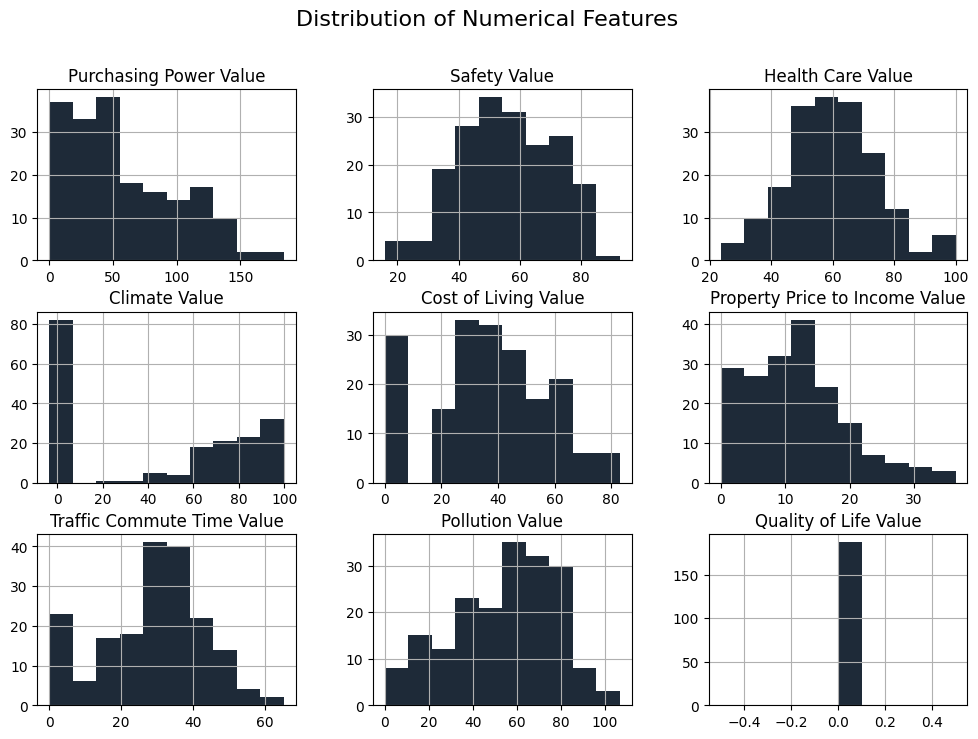

In [17]:
df.hist(figsize=(12, 8), color=colors[0])
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.show()

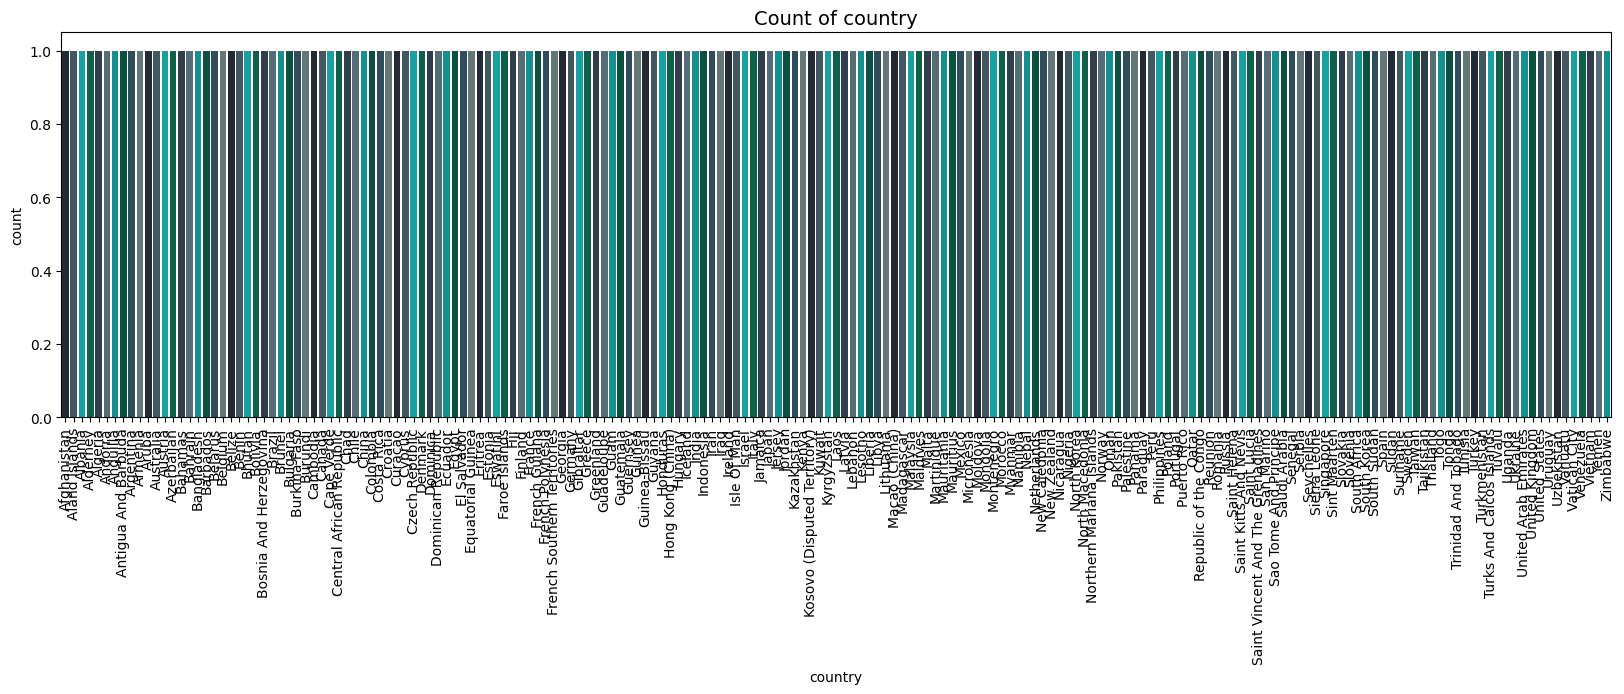

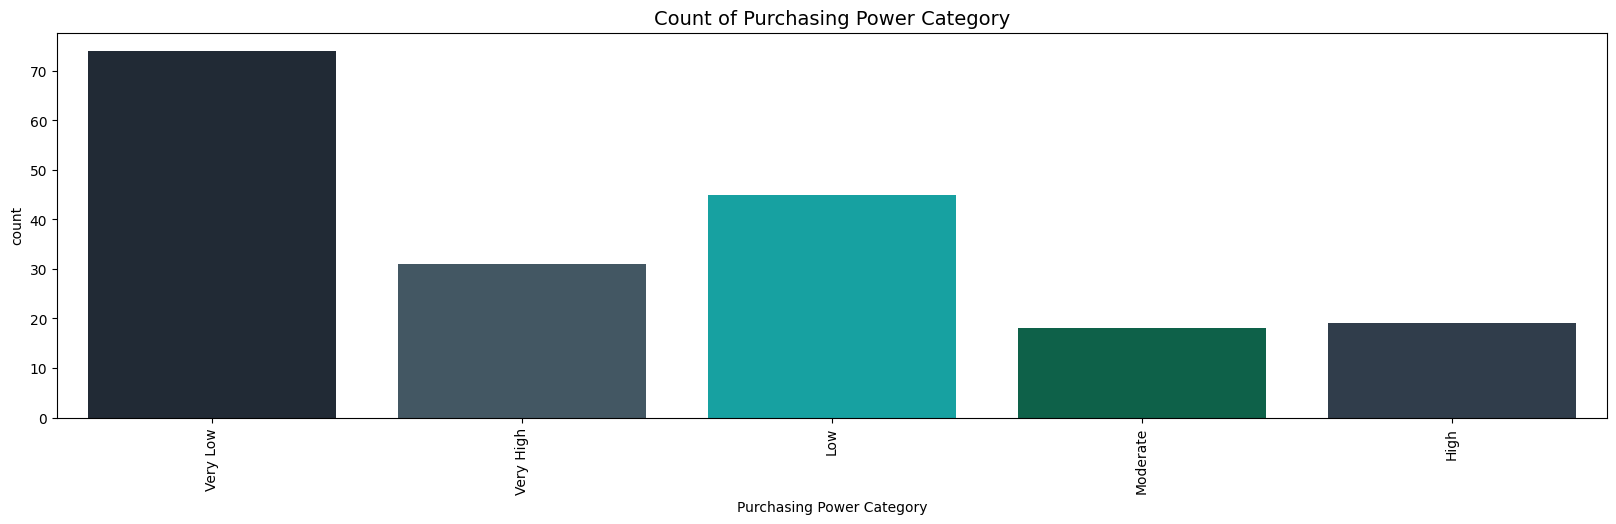

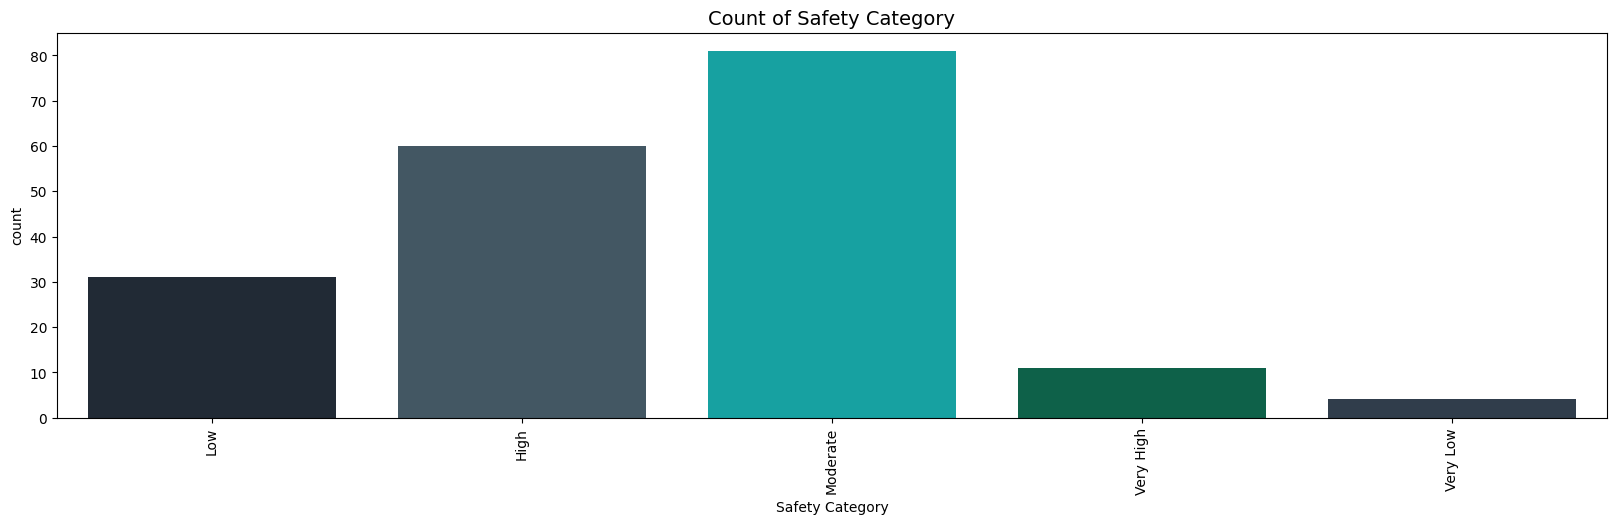

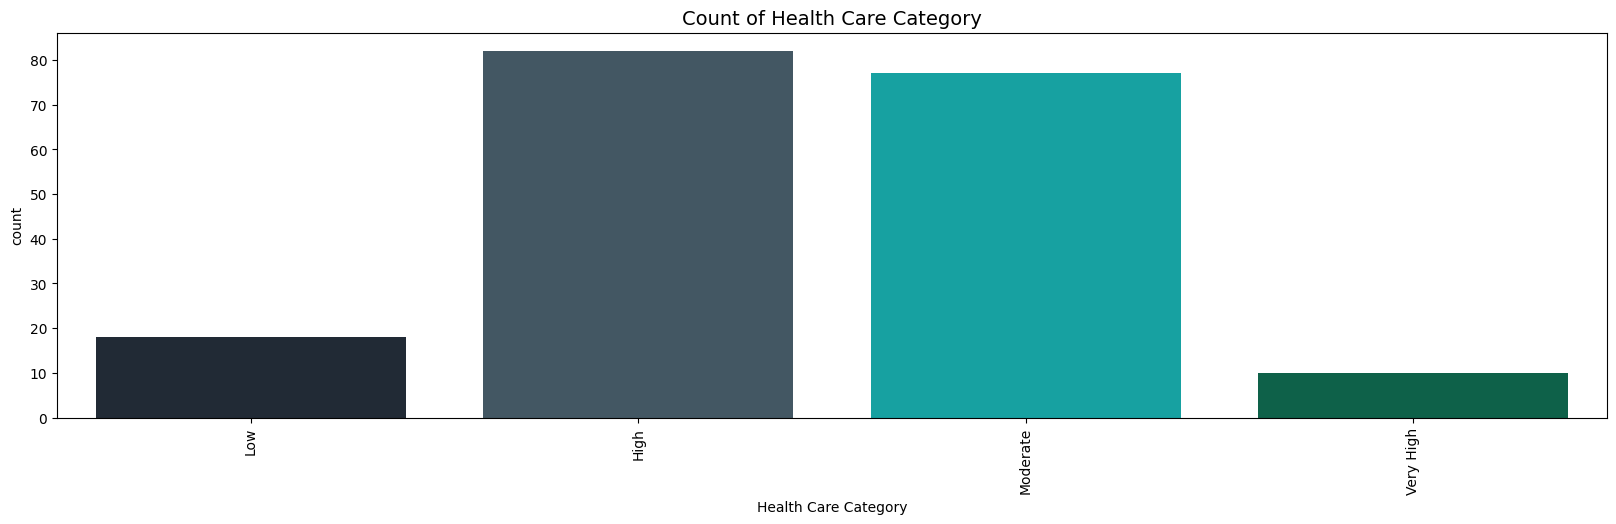

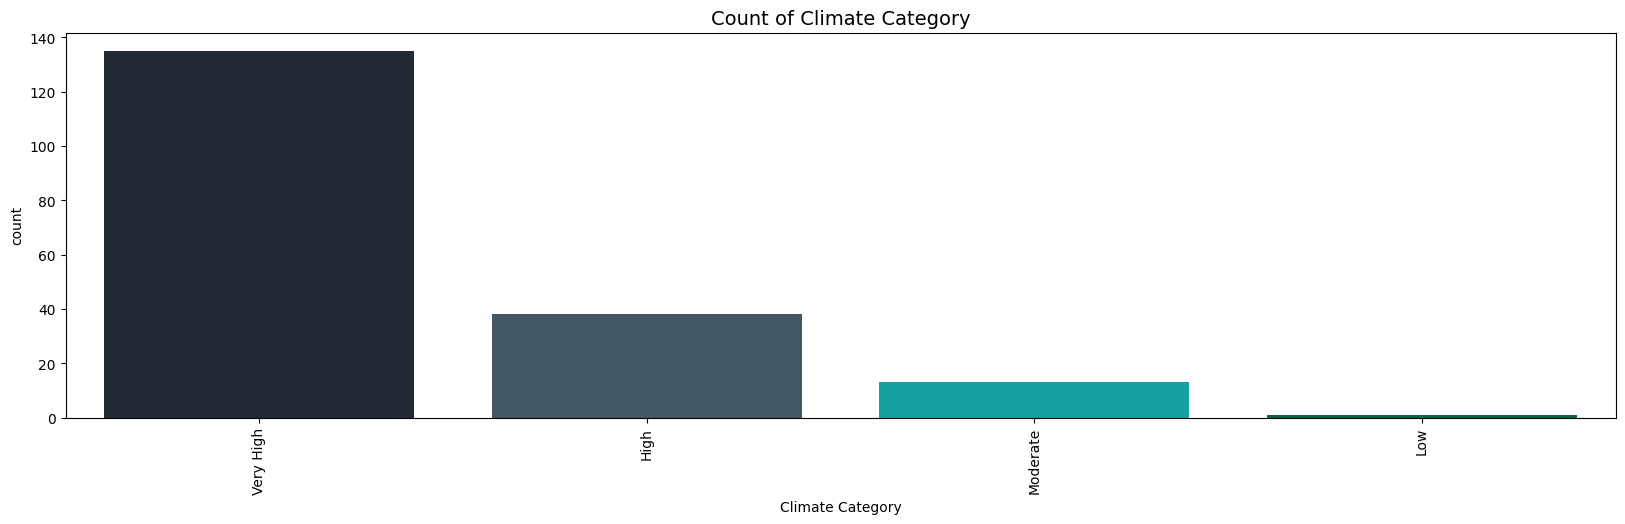

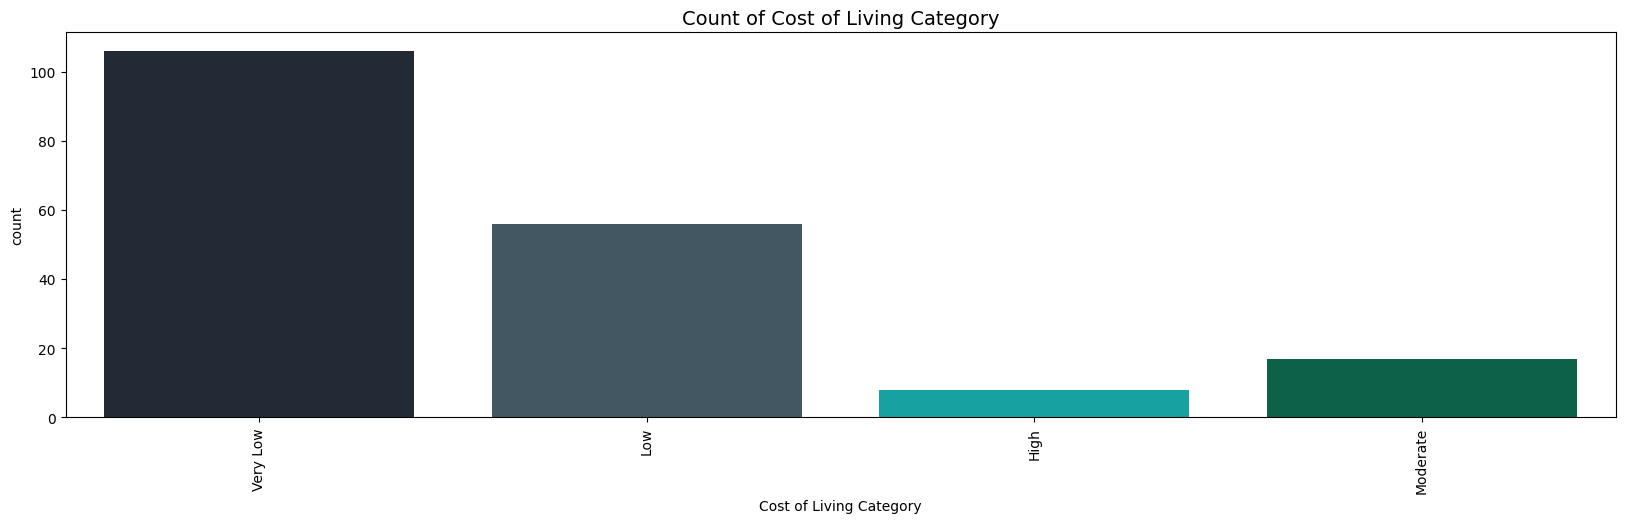

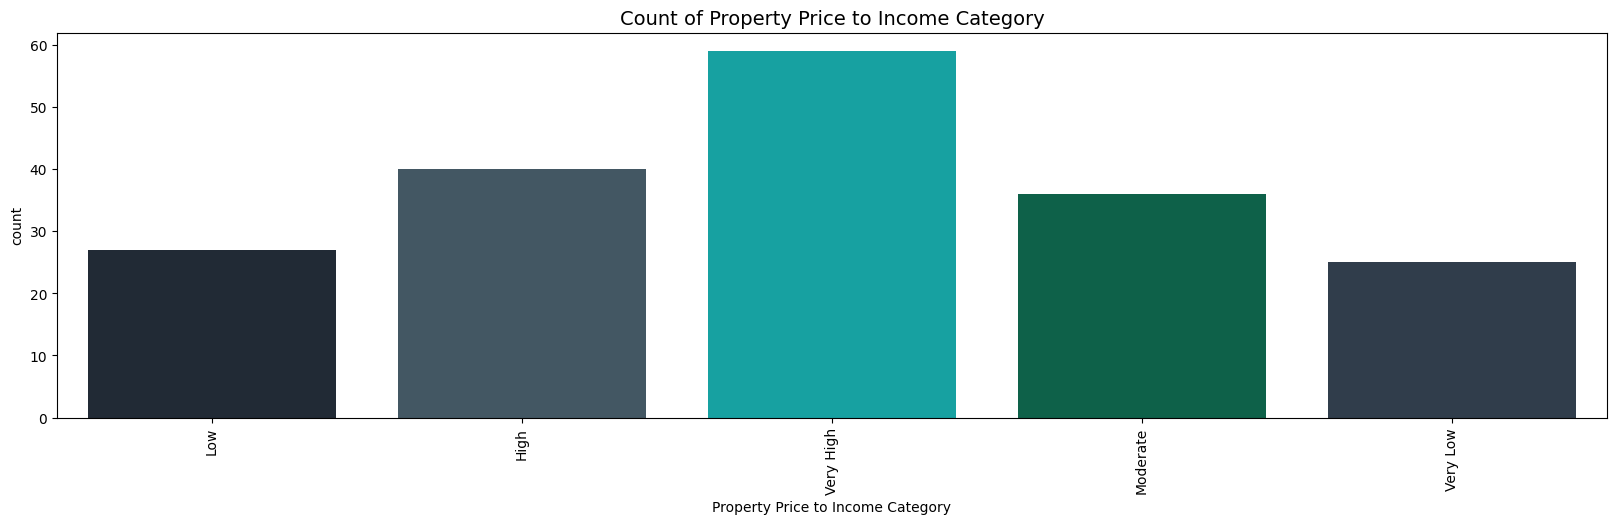

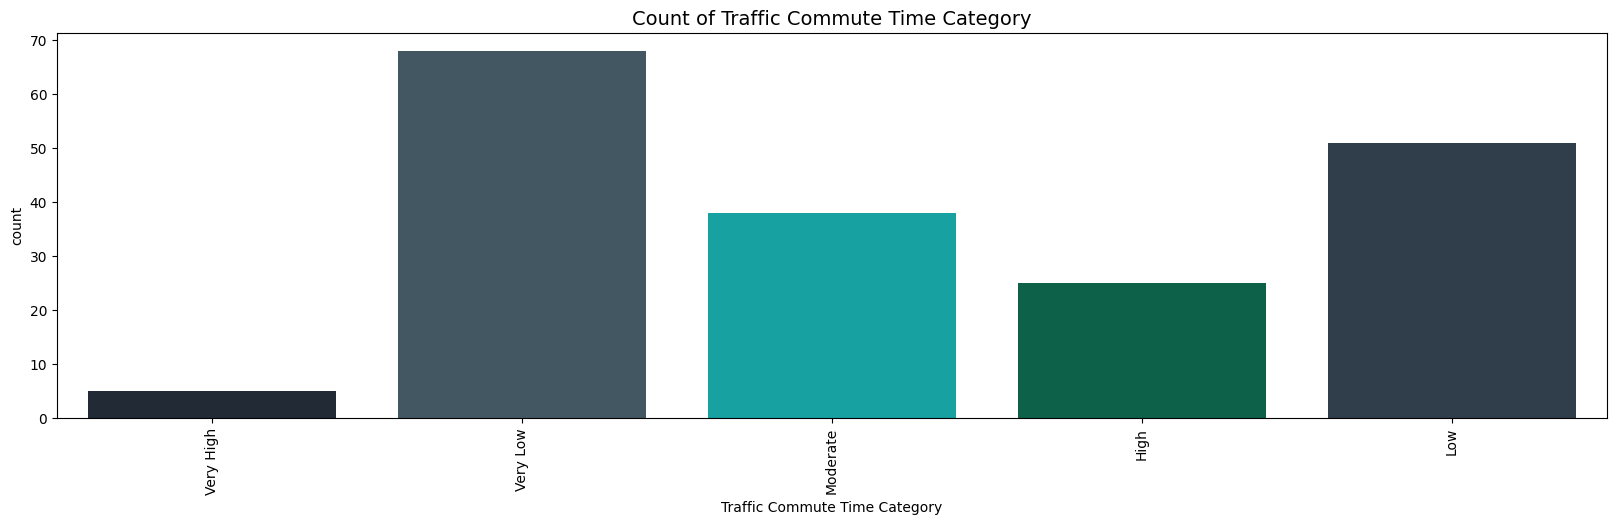

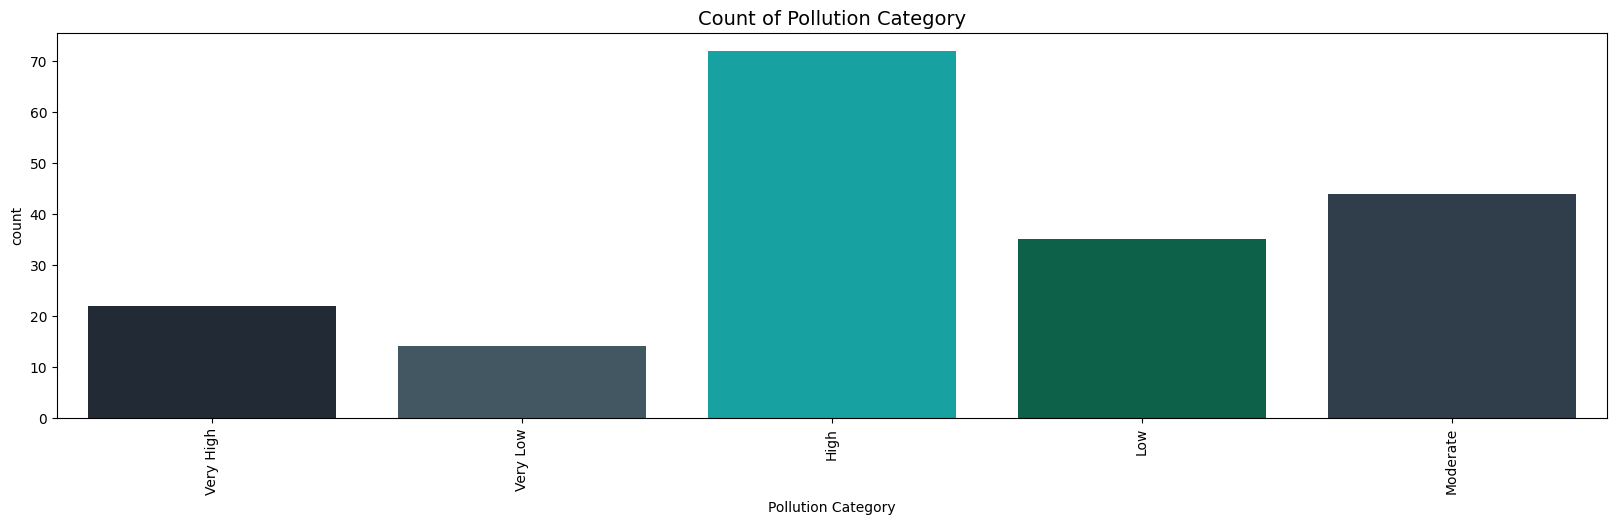

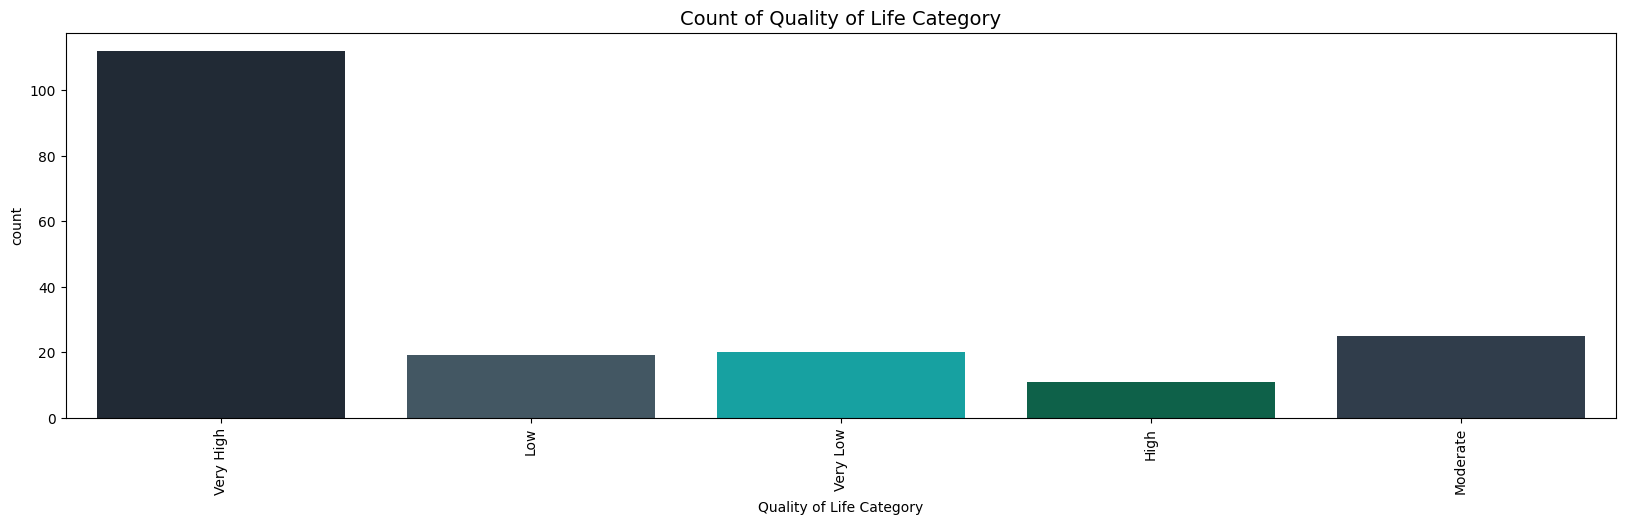

In [18]:
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(20, 5))
    sns.countplot(data=df, x=col, palette=colors)
    plt.title(f'Count of {col}', fontsize=14)
    plt.xticks(rotation=90)
    plt.show()

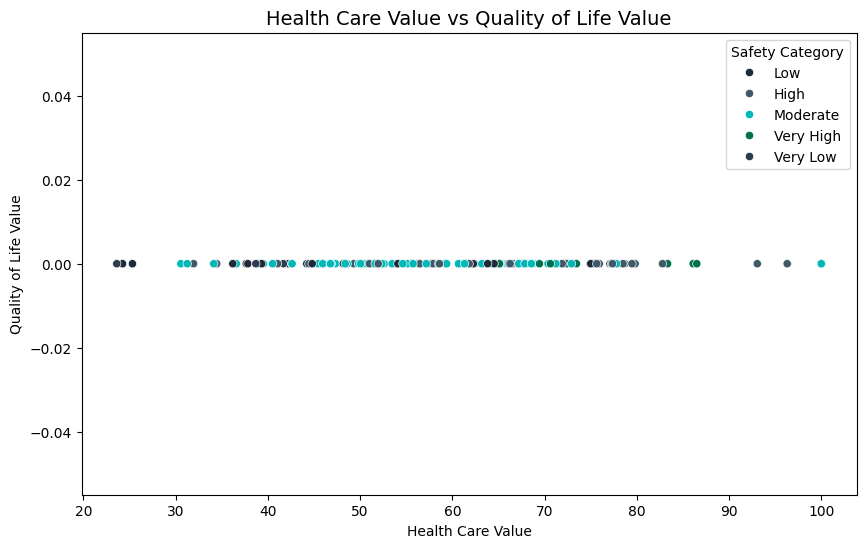

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Health Care Value'], y=pd.to_numeric(df['Quality of Life Value'], errors='coerce'), hue=df['Safety Category'], palette=colors)
plt.title('Health Care Value vs Quality of Life Value', fontsize=14)
plt.xlabel('Health Care Value')
plt.ylabel('Quality of Life Value')
plt.show()

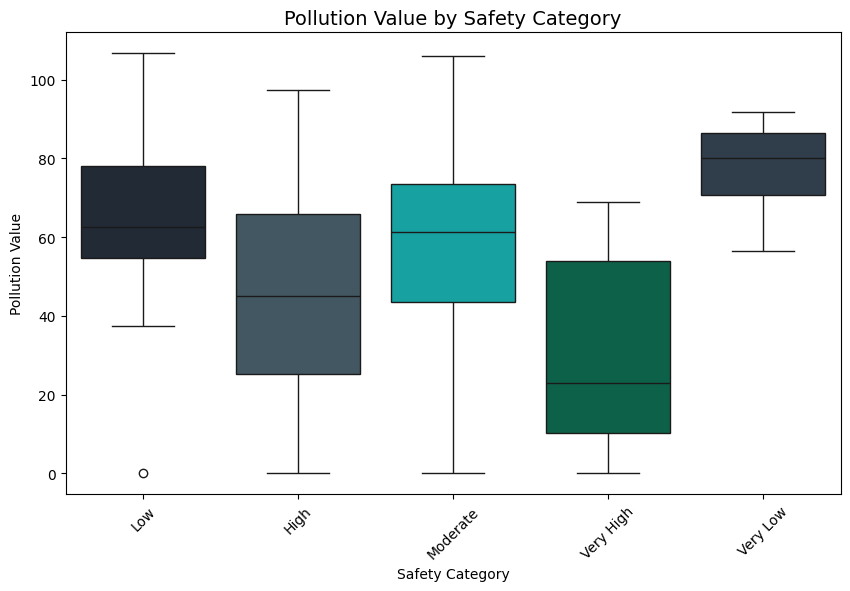

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Safety Category', y='Pollution Value', palette=colors)
plt.title('Pollution Value by Safety Category', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [21]:
encoder = LabelEncoder()

label_mappings = {}

for col in df.select_dtypes('object'):
    df[col] = encoder.fit_transform(df[col])
    label_mappings[col] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

for col, mapping in label_mappings.items():
    print(f"Column: {col}")
    for label, code in mapping.items():
        print(f"{code} -> {label}")
    print()

Column: country
0 -> Afghanistan
1 -> Aland Islands
2 -> Albania
3 -> Alderney
4 -> Algeria
5 -> Andorra
6 -> Anguilla
7 -> Antigua And Barbuda
8 -> Argentina
9 -> Armenia
10 -> Aruba
11 -> Australia
12 -> Austria
13 -> Azerbaijan
14 -> Bahamas
15 -> Bahrain
16 -> Bangladesh
17 -> Barbados
18 -> Belarus
19 -> Belgium
20 -> Belize
21 -> Benin
22 -> Bhutan
23 -> Bolivia
24 -> Bosnia And Herzegovina
25 -> Brazil
26 -> Brunei
27 -> Bulgaria
28 -> Burkina Faso
29 -> Burundi
30 -> Cambodia
31 -> Canada
32 -> Cape Verde
33 -> Central African Republic
34 -> Chad
35 -> Chile
36 -> China
37 -> Colombia
38 -> Costa Rica
39 -> Croatia
40 -> Curacao
41 -> Cyprus
42 -> Czech Republic
43 -> Denmark
44 -> Dominica
45 -> Dominican Republic
46 -> Ecuador
47 -> Egypt
48 -> El Salvador
49 -> Equatorial Guinea
50 -> Eritrea
51 -> Estonia
52 -> Eswatini
53 -> Faroe Islands
54 -> Fiji
55 -> Finland
56 -> France
57 -> French Guiana
58 -> French Polynesia
59 -> French Southern Territories
60 -> Georgia
61 -> G

In [22]:
from sklearn.model_selection import train_test_split

X = df.drop('Quality of Life Value',axis = 1)
y = df['Quality of Life Value']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape)

(149, 18) (38, 18)


In [24]:
knn = KNeighborsRegressor()
knn_model = knn.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [25]:
knn_mse = mean_squared_error(y_test, y_pred)
knn_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {knn_mse}")
print(f"R2 Score: {knn_r2}")

Mean Squared Error: 0.0
R2 Score: 1.0


In [26]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [27]:
lr_mse = mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {lr_mse}")
print(f"R2 Score: {lr_r2}")

Mean Squared Error: 0.0
R2 Score: 1.0


In [28]:
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train),
y_pred = xgb_model.predict(X_test)

In [29]:
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {xgb_mse}")
print(f"R2 Score: {xgb_r2}")

Mean Squared Error: 0.0
R2 Score: 1.0


In [30]:
models = ['KNN', 'XGBoost','Linear Regression']
mse_scores = [knn_mse, xgb_mse, lr_mse]
r2_scores = [knn_r2, xgb_r2, lr_r2]

mse_values = [f'{score:.4f}' for score in mse_scores]  
r2_values = [f'{score:.4f}' for score in r2_scores]    

results_df = pd.DataFrame({
    'Model': models,
    'MSE': mse_values,
    'R^2': r2_values
})
print(results_df)

               Model     MSE     R^2
0                KNN  0.0000  1.0000
1            XGBoost  0.0000  1.0000
2  Linear Regression  0.0000  1.0000
